In [12]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import math
import ephem
from datetime import datetime, time, timedelta
from math import pi, cos, sin
from scipy import optimize
from joblib import Parallel, delayed
from mpl_toolkits.basemap import Basemap

import diurnal_config


%run diurnal_utils.py
%run fetch_model_helper.py

# Notebook for exploring local CMIP6 data downloaded with `cmip6_downloader.py`

In [2]:
# # path_to_cmip_dirs = '/export/data1/cchristo/cmip6_clouds/download_from_source/'
# cmip_rel_dir = '/export/data1/cchristo/CMIP6_precip/pr_3hr_historical/'
# save_figs_dir = 'figs/diurnal_cycle_figs/'

# save_figs_dir = '/home/cchristo/proj_tapio/figs/diurnal_cycle_figs/gfdl_cm4_2000_2010_precip/'
# save_output_dir = '/export/data1/cchristo/diurnal_analysis_results/'



In [8]:
cmip_identifier = 'CMIP6'
start_date = '1985-01'
end_date = '1986-01'
# end_date = '2006-01'

cmip6_model_names = diurnal_config.cmip6_to_cmip5_map.keys()
all_model_names = list(cmip6_model_names)
cmip_rel_dir = '/export/data1/cchristo/CMIP6_precip/pr_3hr_historical/'

In [10]:
cmip6_model_names


dict_keys(['GFDL-ESM4', 'GFDL-CM4', 'FGOALS-g3', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0'])

In [35]:
FLUX_TO_MM_HR = 60*60

In [14]:
# model_list = os.listdir(path_to_cmip_dirs)
# print(model_list)
# path_to_cmip_files = path_to_cmip_dirs + 'GFDL-CM4/'
# file_list = os.listdir(path_to_cmip_files)
# for file in file_list: print(file)

path_to_cmip_files = get_path_to_desired_model_cmip6(cmip_rel_dir, 
                          desired_model='GFDL-ESM4',)

In [16]:

ds = xr.open_mfdataset(path_to_cmip_files, combine='by_coords')

# ds = ds.sel(time=slice('1986','2005'))
# ds = ds.sel(time = slice('2000-06', '2001-05'))
ds = ds.sel(time = slice(start_date, end_date))
ds = ds.sel(lat= slice(-60, 60))

In [17]:
ds['pr']

<xarray.DataArray 'pr' (time: 3168, lat: 120, lon: 288)>
dask.array<getitem, shape=(3168, 120, 288), dtype=float32, chunksize=(3168, 120, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * lat      (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 ... 56.5 57.5 58.5 59.5
  * time     (time) object 1985-01-01 01:30:00 ... 1986-01-31 22:30:00
Attributes:
    long_name:      Precipitation
    units:          kg m-2 s-1
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    standard_name:  precipitation_flux
    interp_method:  conserve_order1
    original_name:  pr

In [27]:
field_id = 'pr'
grid_time_resolution_hours = 3
time_resolution_hours = 1

hour_bins = np.arange(time_resolution_hours, 24 + time_resolution_hours, time_resolution_hours)
grid_hour_bins = np.arange(grid_time_resolution_hours, 24 + grid_time_resolution_hours, grid_time_resolution_hours)

lon_mesh, lat_mesh = np.meshgrid(ds['lon'].values, ds['lat'].values)
ds_seasons = ds.groupby('time.season')

mu_season = {}
sigma_season = {}
ampl_season = {}
phase_season = {}

for season_i, season_ds in ds_seasons:
    if season_i != 'DJF':
        break
    print(season_i)
    lst_da = compute_lst_array(season_ds, 
                               bin_interval = grid_time_resolution_hours, # time_resolution_hours,
                               bin_bool = True, 
                               lon_mesh = lon_mesh, 
                               lat_mesh = lat_mesh,
                               field_id = field_id)
    lst_array = lst_da.values
    lst_array[lst_array == 0] = 24
    field_season_array = season_ds[field_id].values

    field_season_mean = field_season_array.mean(axis = 0)

    # compute mu_ij
#         mu_ij = np.zeros(field_season_array.shape[-2:])
    mu_ij = np.zeros(field_season_array.shape[-2:])
#         sigma_ij = np.zeros((len(hour_bins),) + field_season_array.shape[-2:])

    f_bar_ks = {}
    for hour_i in grid_hour_bins:
        masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

        # mean for a given season, LST
        f_bar_k = np.nanmean(masked_field, axis = 0)
        f_bar_k[np.isnan(f_bar_k)] = 0
        f_bar_ks[hour_i] = f_bar_k
        mu_ij  += f_bar_k
#             mu_ij_[ii,:,:] = f_bar_k
#         hour_means = np.stack(list(f_bar_ks.values()))
#             plt.imshow(f_bar_k, origin = 'lower')
#             plt.show()

    mu_ij = (1/len(grid_hour_bins))*mu_ij
#         mu_ij = (1/8)*mu_ij
    mu_season[season_i] = mu_ij

    sigma_ij = np.zeros(field_season_array.shape[-2:])
    for hour_i in grid_hour_bins:
        masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

        # mean for a given season, LST
        f_bar_k = np.nanmean(masked_field, axis = 0)
        f_bar_k[np.isnan(f_bar_k)] = 0
        sigma_ij += np.square(f_bar_k - mu_ij)

    sigma_ij = np.sqrt((1/(len(grid_hour_bins) - 1))*sigma_ij)
#         sigma_ij = np.sqrt((1/7)*sigma_ij)
#         sigma_ij = np.nanstd(sigma_ij, axis = 0)

    sigma_season[season_i] = sigma_ij

    lst_da = compute_lst_array(season_ds, 
                               bin_interval = time_resolution_hours,
                               bin_bool = True, 
                               lon_mesh = lon_mesh, 
                               lat_mesh = lat_mesh,
                               field_id = field_id)
    lst_array = lst_da.values
    lst_array[lst_array == 0] = 24
    field_season_array = season_ds[field_id].values

    field_season_mean = field_season_array.mean(axis = 0)

    # compute hourly grid means needed for cos fit
    f_bar_ks = {}
    for ii in range(len(hour_bins)):
        hour_i = hour_bins[ii]
        masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

        # mean for a given season, LST
        f_bar_k = np.nanmean(masked_field, axis = 0)
        f_bar_k[np.isnan(f_bar_k)] = 0
        f_bar_ks[hour_i] = f_bar_k

    hour_means = np.stack(list(f_bar_ks.values()))

    print('Performing Cos Fit')
#         res = cos_fit_grid(field_season_array, lst_array, hour_means, hour_bins)
    res = cos_fit_grid_average(hour_means, hour_bins)
    print('Finished Cos Fit')
    ampl_season[season_i], phase_season[season_i] = res[0], res[1]

  3%|▎         | 30/968 [00:00<00:03, 296.53it/s]

DJF


100%|██████████| 968/968 [00:03<00:00, 287.72it/s]
/home/cchristo/.conda/envs/diurnal_research/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: Mean of empty slice
  0%|          | 0/120 [00:00<?, ?it/s]

Performing Cos Fit


100%|██████████| 120/120 [06:10<00:00,  3.09s/it]

Finished Cos Fit


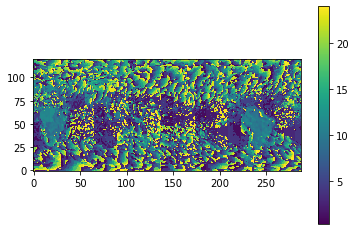

In [34]:
# resr
# plt.imshow(res[1],origin = 'lower')
plt.colorbar()

In [23]:
rr = cos_fit_grid_average(field_season_array, hour_bins)

100%|██████████| 120/120 [00:04<00:00, 27.28it/s]


In [24]:
rr

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]))

In [ ]:
ds_sub = ds['pr'].to_dataset()
mu_season, sigma_season, ampl_season, phase_season = diurnal_analysis(ds_sub, 
                                                                      field_id = 'pr', 
                                                                      grid_time_resolution_hours = 3,
                                                                      time_resolution_hours = 1)

  0%|          | 42/11520 [00:00<00:27, 415.91it/s]

DJF


100%|██████████| 11520/11520 [00:27<00:00, 418.82it/s]
/home/cchristo/proj_tapio/diurnal_research/diurnal_utils.py:269: RuntimeWarning: Mean of empty slice
  f_bar_k = np.nanmean(masked_field, axis = 0)
  0%|          | 0/120 [00:00<?, ?it/s]

Performing Cos Fit


  0%|          | 29/11776 [00:00<00:41, 282.76it/s]

Finished Cos Fit
JJA


100%|██████████| 11776/11776 [00:28<00:00, 409.69it/s]
/home/cchristo/proj_tapio/diurnal_research/diurnal_utils.py:269: RuntimeWarning: Mean of empty slice
  f_bar_k = np.nanmean(masked_field, axis = 0)
  0%|          | 0/120 [00:00<?, ?it/s]

Performing Cos Fit


  0%|          | 25/11776 [00:00<00:48, 241.71it/s]

Finished Cos Fit
MAM


100%|██████████| 11776/11776 [00:28<00:00, 418.80it/s]
/home/cchristo/proj_tapio/diurnal_research/diurnal_utils.py:269: RuntimeWarning: Mean of empty slice
  f_bar_k = np.nanmean(masked_field, axis = 0)
  0%|          | 0/120 [00:00<?, ?it/s]

Performing Cos Fit


 77%|███████▋  | 92/120 [30:54<09:17, 19.89s/it]

In [ ]:
# ds

In [45]:
FLUX_TO_MM_HR

3600

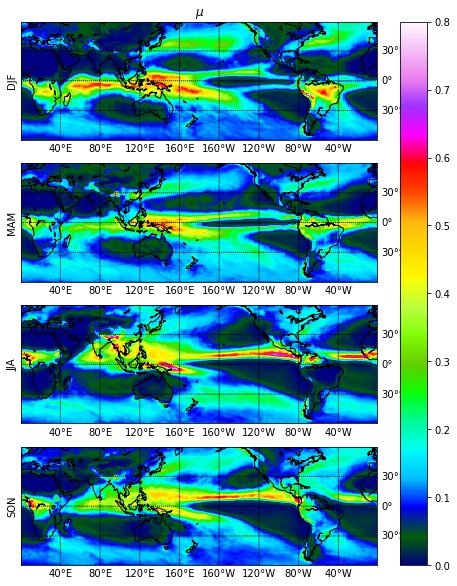

In [84]:
mu_mm_hr = {key:FLUX_TO_MM_HR*val for key, val in mu_season.items()}
make_four_panel(mu_mm_hr, 
                lats = ds['lat'].values, 
                lons = ds['lon'].values,
#                 cmap = plt.get_cmap('bwr'),
                cmap = plt.get_cmap('gist_ncar'),
                vmin = 0,
                vmax = 0.8,
                title = r'$\mu$',
#                 axis = plt.axis([220, 300, 10, 50]), 
                save_fig_path= save_figs_dir + 'GFDL_CM4_means_pr.png')

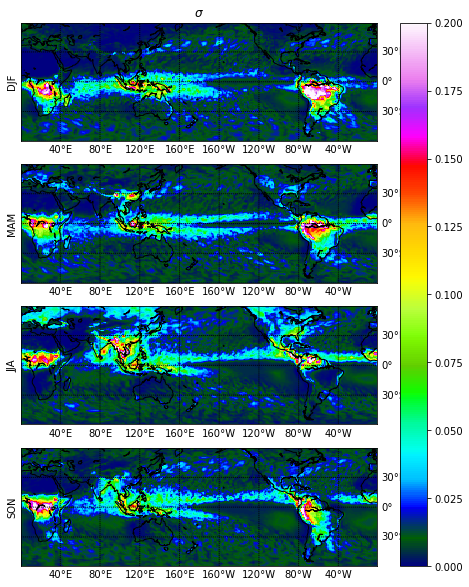

In [85]:
sigma_mm_hr = {key:FLUX_TO_MM_HR*val for key, val in sigma_season.items()}


make_four_panel(sigma_mm_hr , 
                lats = ds['lat'].values, 
                lons = ds['lon'].values,
#                 vmax = 0.1, 
                vmin = 0, vmax = 0.2, 
#                 cmap = plt.get_cmap('bwr'),
                cmap = plt.get_cmap('gist_ncar'),
                title = r'$\sigma$',
#                 axis = plt.axis([220, 300, 10, 50]), 
                save_fig_path= save_figs_dir + 'GFDL_CM4_stds_pr.png')

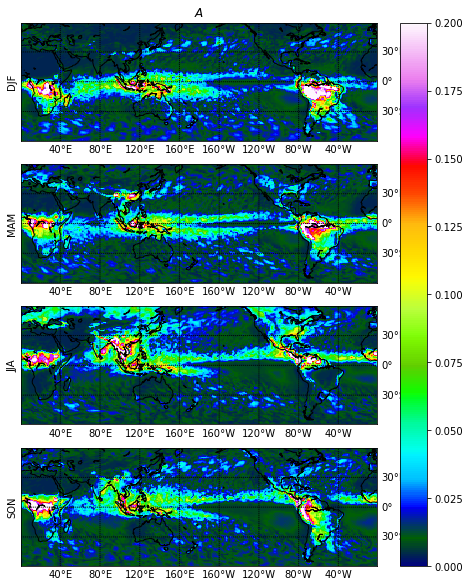

In [91]:
ampl_mm_hr = {key:FLUX_TO_MM_HR*val for key, val in ampl_season.items()}



make_four_panel(ampl_mm_hr, 
                lats = ds['lat'].values, 
                lons = ds['lon'].values,
#                 vmax = 0.000015, 
#                 cmap = plt.get_cmap('bwr'),
                vmin = 0, vmax = 0.2, 
                cmap = plt.get_cmap('gist_ncar'),
                title = r'$A$',
#                 axis = plt.axis([220, 300, 10, 50]), 
                save_fig_path= save_figs_dir + 'GFDL_CM4_ampl_pr.png')

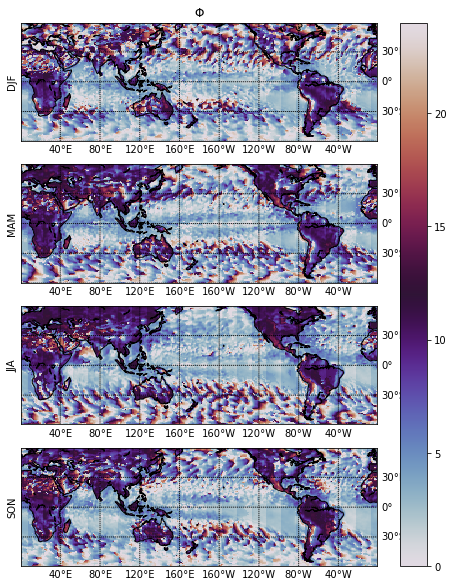

In [93]:
make_four_panel(phase_season , 
                lats = ds['lat'].values, 
                lons = ds['lon'].values,
                vmin = 0, vmax = 24, 
                cmap = plt.get_cmap('twilight'),
                title = r'$\Phi$',
#                 axis = plt.axis([220, 300, 10, 50]), 
                save_fig_path= save_figs_dir + 'GFDL_CM4_phase_pr.png')

In [30]:
out_ds = xr.Dataset()
out_ds['mu_season'] = make_da_from_dict(mu_season, ds)
out_ds['sigma_season'] = make_da_from_dict(sigma_season,ds)
out_ds['ampl_season'] = make_da_from_dict(ampl_season, ds)
out_ds['phase_season'] = make_da_from_dict(phase_season,ds)

In [31]:
out_ds.to_netcdf(save_output_dir + 'gfdl_cm4_2000_2010_precip.nc')